In [39]:
# import packages
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as smm
from adjustText import adjust_text
import os

from statannotations.Annotator import Annotator

def plot_boxplot_by_treatment(d, x_val, y_val, order, pairs, palette):
    # Draw the boxplot with a semi-transparent fill (alpha=0.5) applied via boxprops.
    ax = sns.boxplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        palette=palette, 
        order=order, 
        width=0.5, 
       # capsize=0.1, 
        linewidth=1,

        showfliers=False
    )
    # Overlay the stripplot
    sp = sns.stripplot(
        data=d, 
        x=x_val, 
        y=y_val, 
        dodge=False, 
        jitter=0.1, 
        alpha=1,  
        order=order, 
        color='black',
        #palette=palette,
        size=3
    )

    ax.set_ylim(0, np.max(d[y_val])*1.2)

    #plt.ylim(0, plt.ylim()[1])
    # Shift the stripplot points slightly to the left.
    shift = 0.4  # Adjust this value as needed
    for i, coll in enumerate(sp.collections):
        # if i == 0:
        #     shift = 0.4
        # elif i == 1:
        #     shift = 0.4
        # elif i == 2:
        #     shift = 0.4
            
        offsets = coll.get_offsets()
        # Subtract from the x-coordinate to move left
        offsets[:, 0] = offsets[:, 0] + shift
        coll.set_offsets(offsets)
    # Add statistical annotations
    annotator = Annotator(ax, pairs, data=d, x=x_val, y=y_val, order=order)
    annotator.configure(test='t-test_ind', text_format='full', loc='outside',
                        verbose=2, show_test_name=False, line_offset_to_group=1000,  # Increases space between the brackets and the plot
    text_offset=5)
    annotator.apply_and_annotate()

    plt.xticks(rotation=0)
    plt.xlabel('')

    # Adjust the boxes so that the face remains semi-transparent while the edge is opaque.
    # Try iterating over both ax.artists and ax.patches.
    for patch in ax.patches:
        # Get the current facecolor (an RGBA tuple)
        fc = patch.get_facecolor()
        # Set the facecolor to have your desired alpha (e.g., 0.5)
        patch.set_facecolor((fc[0], fc[1], fc[2], 0.5))
        # Set the edgecolor to the same RGB but fully opaque (alpha=1)
        #patch.set_edgecolor((fc[0], fc[1], fc[2], 1.0))
        patch.set_linewidth(1)

    return ax


#plt.savefig('../../paper/main_plots/tmrm_choline_boxplot.png', dpi=300, bbox_inches='tight')


In [40]:
# Load data 
# Load the Excel file
output_dir = '../../LCMS/'
excel_file = os.path.join(output_dir, '7689.SUB15127_MetabolomicsData_Targeted.xlsx')
sheet_name = 'Targeted'  # Replace with the actual sheet name if different
data = pd.read_excel(excel_file, sheet_name=sheet_name)

# remove outliers as determined by Core (Y_A, E3_C and YC_F (SPL1, 11 and 24))
data = data[(data['Unnamed: 1']!='Y_A ') & (data['Unnamed: 1']!='E3_C ') & (data['Unnamed: 1']!='YC_F ')]


In [41]:
data['Unnamed: 1'].unique()

array([nan, 'Y_B ', 'Y_C ', 'Y_D ', 'Y_E ', 'Y_F ', 'Y_G ', 'Y_H ',
       'E3_A ', 'E3_B ', 'E3_D ', 'E3_E ', 'E3_F ', 'E3_G ', 'E3_H ',
       'E3_I ', 'E3_J ', 'YC_A ', 'YC_B ', 'YC_C ', 'YC_D ', 'YC_E ',
       'YC_G ', 'YC_H ', 'G2_A ', 'G2_B ', 'G2_C ', 'G2_D ', 'G2_E ',
       'con_1 ', 'con_2 ', 'con_c-1 ', 'con_c-2 ', 'B1 media_no_cells',
       'B2 media_no_cells', 'BC1 media_no_cells', 'BC2 media_no_cells',
       'Y1 media', 'Y2 media', 'Y3 media', 'Y4 media', 'YC1 media',
       'YC2 media', 'YC3 media', 'YC4 media'], dtype=object)

In [42]:
data.iloc[34:38].iloc[:,5:]

,Glutamine,Alphaketoglutarate,Betaine,hypoxanthine,AcetylCholine,CDP,CDP-choline,Choline,GlycerylPhosphorylCholine,PhosphorylCholine,Carnitine,AcetylCarnitine,Propionylcarnitine,C10-carnitine,C12-carnitine,C14-carnitine,Oleoylcarnitine,Palmitoylcarnitine,Stearoylcarnitine (C18:0)
37,6943979,310446,35599991,2341182,18177846,N/F,N/F,15157762,194145,45687235,129924512,547444,N/F,N/F,N/F,N/F,N/F,N/F,N/F
38,354076212,674690,N/F,20570057,485711,690768,N/F,2357084070,267497790,277163,5746418939,N/F,N/F,N/F,N/F,N/F,N/F,307924,N/F
39,322984888,612090,N/F,17202227,761499,747302,N/F,2124104423,261885252,117438,5775177534,139041,N/F,N/F,N/F,N/F,17856,98843,N/F
40,362744021,615013,N/F,23373674,586175,787015,103756793,2749277159,267414698,43789220,5734646996,56024,N/F,N/F,N/F,N/F,25205,57394,N/F


In [43]:
experiment1 = data[data['Unnamed: 3']=='experiment_1']
experiment1 = data[data['Unnamed: 3']=='experiment_1']

# replace N/F with NaN
experiment1.replace('N/F', np.nan, inplace=True)
experiment1 = pd.concat([experiment1.T, data.loc[2]], axis=1).T

experiment1['grp'] = [str(x).split('_')[0] for x in experiment1['Unnamed: 1']]
experiment1_sele = experiment1[['grp'] + list(experiment1.columns[1:-1])]
# drop any species that were not detected in one or more samples
experiment1_sele.dropna(axis=1, inplace=True)
experiment1_sele.replace('N/F', 0, inplace=True)
# subtract blank from remaining samples
out = []
for col in experiment1_sele.columns[1:]:
    out.append(experiment1_sele[col].values[:-1]-experiment1_sele[col].values[-1])

df = pd.DataFrame(np.vstack(out)).T
df.columns = experiment1_sele.columns[1:]
df['grp'] = experiment1_sele['grp'].values[:-1]


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_68673/2264526376.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  experiment1.replace('N/F', np.nan, inplace=True)
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_68673/2264526376.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiment1.replace('N/F', np.nan, inplace=True)
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_68673/2264526376.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas

In [44]:
temp = experiment1[['Targeted data', 'Choline', 'grp']]#_sele[['grp', 'Choline']]
temp.loc[((temp['grp']!='G2') & (temp['grp']!='con')) & (temp['grp']!='nan')]

,Targeted data,Choline,grp
4,SUB15127p7_SPL02,1419499,Y
5,SUB15127p7_SPL03,2164558,Y
6,SUB15127p7_SPL04,6667375,Y
7,SUB15127p7_SPL05,5348382,Y
8,SUB15127p7_SPL06,5140470,Y
9,SUB15127p7_SPL07,6415915,Y
10,SUB15127p7_SPL08,73181798,Y
11,SUB15127p7_SPL09,71390254,E3
12,SUB15127p7_SPL10,10452681,E3
14,SUB15127p7_SPL12,15189731,E3


In [47]:
names = df.columns[:-1]

/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na o

E3 vs. Y: t-test independent samples, P_val:1.024e-01 t=1.747e+00
Y vs. YC: t-test independent samples, P_val:5.221e-01 t=6.594e-01
E3 vs. G2: t-test independent samples, P_val:1.264e-01 t=1.642e+00
E3 vs. Y: t-test independent samples, P_val:3.420e-01 t=9.836e-01
Y vs. YC: t-test independent samples, P_val:9.779e-01 t=2.834e-02
E3 vs. G2: t-test independent samples, P_val:2.446e-01 t=1.224e+00


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


E3 vs. Y: t-test independent samples, P_val:3.523e-01 t=9.621e-01
Y vs. YC: t-test independent samples, P_val:2.336e-01 t=-1.254e+00
E3 vs. G2: t-test independent samples, P_val:5.376e-01 t=6.346e-01


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


E3 vs. Y: t-test independent samples, P_val:7.421e-02 t=1.929e+00
Y vs. YC: t-test independent samples, P_val:3.213e-01 t=-1.034e+00
E3 vs. G2: t-test independent samples, P_val:3.439e-01 t=9.854e-01


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


E3 vs. Y: t-test independent samples, P_val:6.434e-01 t=-4.732e-01
Y vs. YC: t-test independent samples, P_val:2.214e-04 t=-5.201e+00
E3 vs. G2: t-test independent samples, P_val:8.969e-05 t=-5.764e+00


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


E3 vs. Y: t-test independent samples, P_val:1.517e-01 t=1.516e+00
Y vs. YC: t-test independent samples, P_val:6.819e-04 t=-4.537e+00
E3 vs. G2: t-test independent samples, P_val:1.172e-06 t=-8.949e+00


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


E3 vs. Y: t-test independent samples, P_val:6.906e-02 t=-1.969e+00
Y vs. YC: t-test independent samples, P_val:5.774e-01 t=-5.727e-01
E3 vs. G2: t-test independent samples, P_val:1.474e-02 t=-2.846e+00


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


E3 vs. Y: t-test independent samples, P_val:1.029e-01 t=-1.745e+00
Y vs. YC: t-test independent samples, P_val:8.310e-01 t=-2.181e-01
E3 vs. G2: t-test independent samples, P_val:2.350e-01 t=-1.250e+00
E3 vs. Y: t-test independent samples, P_val:9.746e-02 t=1.776e+00


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Y vs. YC: t-test independent samples, P_val:4.565e-04 t=-4.770e+00
E3 vs. G2: t-test independent samples, P_val:1.113e-01 t=-1.719e+00


/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


E3 vs. Y: t-test independent samples, P_val:9.422e-02 t=-1.795e+00
Y vs. YC: t-test independent samples, P_val:8.866e-03 t=-3.119e+00
E3 vs. G2: t-test independent samples, P_val:1.283e-03 t=-4.177e+00


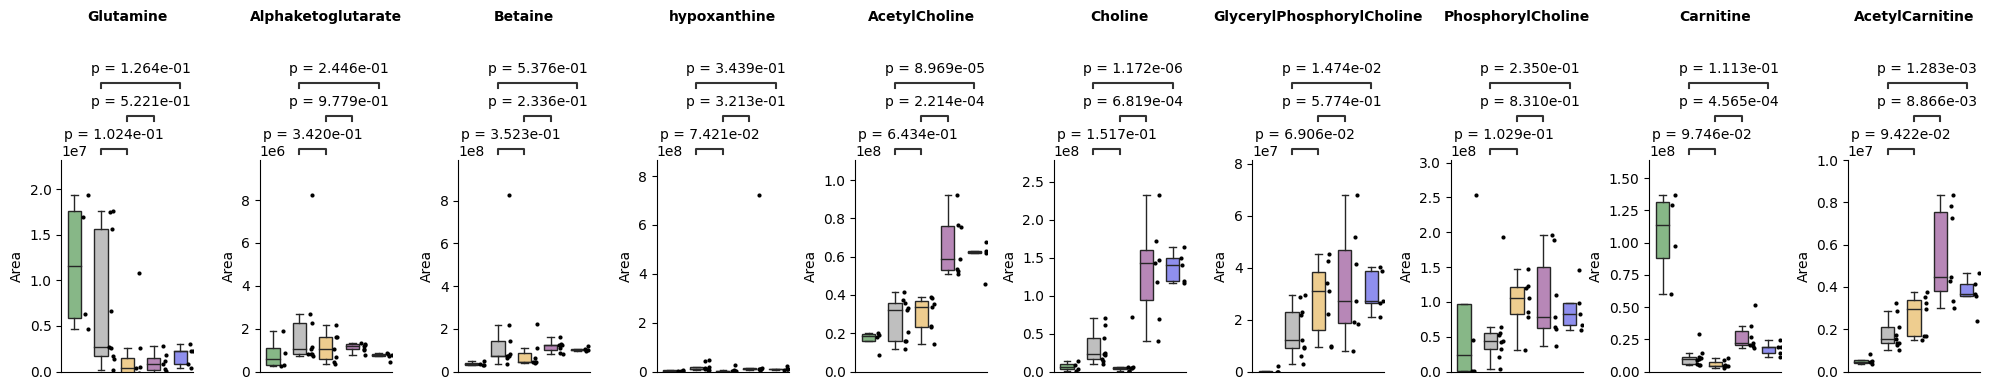

In [49]:

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(1, len(names), figsize=(20, 4), sharey=False)
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
colors = {'con': 'green', 'E3': 'grey', 'Y': 'orange', 'YC': 'purple', 'G2': 'blue'}

for i, name in enumerate(names):
    ax1 = axes[i]
    plt.sca(ax1)
    ax1 = plot_boxplot_by_treatment(df, 'grp', name, order=['con', 'E3', 'Y', 'YC', 'G2'], pairs=[['E3', 'Y'], ['E3', 'G2'], ['Y', 'YC']], palette=colors)
    ax1.set_xticks([])

    # ax1.text(0.4, -0.05, "Media, no cells", ha='center', va='top', transform=ax1.get_xaxis_transform(),
    #          bbox=dict(boxstyle="round,pad=0.2", fc="green", ec="green", alpha=0.5), fontsize=10)

    # ax1.text(2.5, -0.05, "Media, p.Tyr622*", ha='center', va='top', transform=ax1.get_xaxis_transform(),
    #          bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=10)

    # ax1.text(2.5, -0.2, "+ CDP-choline", ha='center', va='top', transform=ax1.get_xaxis_transform(),
    #          bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)
    # ax1.text(2, -0.2, "+ H20", ha='center', va='top', transform=ax1.get_xaxis_transform(),
    #          bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)

    # ax1.text(0.4, -0.2, "+ CDP-choline", ha='center', va='top', transform=ax1.get_xaxis_transform(),
    #          bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)
    # ax1.text(-0.1, -0.2, "+ H20", ha='center', va='top', transform=ax1.get_xaxis_transform(),
    #          bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="white", alpha=0.5), fontsize=10, rotation=45)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_ylabel('Area', fontsize=10)
    ax1.set_title(f'{name}', pad=100, fontsize=10, fontweight='bold')
    ax1.set_ylim(0, np.max(df[name])*1.2)
#axes[0].set_ylabel('Area', fontsize=10)
plt.tight_layout()

#fig.savefig('../../paper/extended_plots/choline_media_lcms.png', dpi=300, bbox_inches='tight', )


E3 vs. Y: t-test independent samples, P_val:7.421e-02 t=1.929e+00
Y vs. YC: t-test independent samples, P_val:3.213e-01 t=-1.034e+00
con vs. E3: t-test independent samples, P_val:7.116e-02 t=-1.997e+00
E3 vs. G2: t-test independent samples, P_val:3.439e-01 t=9.854e-01


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_68673/2309018738.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x = experiment1[['hypoxanthine', 'grp']].replace('N/F', np.nan)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/djuna/Lib

(<Axes: xlabel='grp', ylabel='hypoxanthine'>,
  <statannotations.Annotation.Annotation at 0x17726f700>])

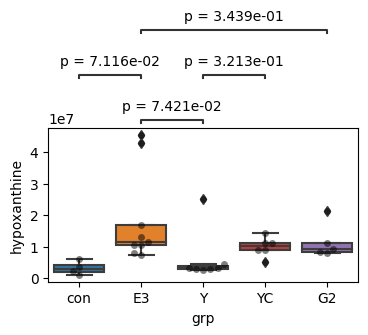

In [50]:
x = experiment1[['hypoxanthine', 'grp']].replace('N/F', np.nan)
x['hypoxanthine'] = x['hypoxanthine'].astype(float)

plt.figure(figsize=(4,2))
order=['con', 'E3', 'Y', 'YC', 'G2']

ax = sns.boxplot(data=x[x.index!=24], x='grp', y='hypoxanthine', order = order)
sns.swarmplot(data=x[x.index!=24], x='grp', y='hypoxanthine', order = order, color='black', alpha=0.5)
pairs=[['E3', 'Y'], ['E3', 'G2'], ['Y', 'YC'], ['E3', 'con']]
annotator = Annotator(ax, pairs, data=x, x='grp', y='hypoxanthine', order=order)
annotator.configure(test='t-test_ind', text_format='full', loc='outside',
                        verbose=2, show_test_name=False, line_offset_to_group=1000,  # Increases space between the brackets and the plot
    text_offset=5)
annotator.apply_and_annotate()
#plt.ylim(0,4)